This notebook aims to conduct feature engineering for our PD Model. We will be selecting features, and conducting feature engineering. 

## 0. Import Libraries

In [1]:
# Standard libraries
import os

# Third-party packages
import wandb
from dotenv import load_dotenv

# Local modules
from init_spark import start_spark
spark = start_spark()

load_dotenv()

wandb.login(key=os.getenv("WANDB_API_KEY"))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/24 23:34:48 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/07/24 23:34:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0813222a-2975-404d-b5d7-c59aabbc168d;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# Pyspark Functions 

# 2. Needed functions for the notebook
from functions import * # Import functions from the functions module

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc


In [3]:

# Remove all runs in the project at the current notebook 
api = wandb.Api()
for run in api.runs(f"wlunlun1212-singapore-management-university/Credit Risk Modeling"):                      
    if run.group == "pd_model_building_2":
        run.delete()

In [4]:
from delta.tables import DeltaTable
from pyspark.sql import SparkSession


# Obtain from Gold Medallion Architecture 
df = spark.read.format("delta")\
    .load("../data/gold/feature_selection_next").cache()
    
df.limit(5).toPandas()

25/07/24 23:34:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,credit_history_years,fico_score,proportion_satisfac_accounts,proportion_satisfac_bc_tl
0,14639393,20000.0,60,E,MORTGAGE,60000.0,Verified,2014-05-01,0,n,...,0.0,0.0,1.0,85.3,228569.0,56111.0,10.666667,672.0,0.888889,1.000000
1,14580137,20000.0,60,E,MORTGAGE,46962.0,Verified,2014-05-01,1,n,...,0.0,0.0,3.0,95.7,250522.0,35505.0,15.416667,672.0,0.888889,1.000000
2,14490894,4800.0,36,B,OWN,30000.0,Verified,2014-05-01,0,n,...,0.0,1.0,4.0,94.7,8300.0,1698.0,18.916667,677.0,0.909091,1.000000
3,14610358,10000.0,60,C,MORTGAGE,50000.0,Source Verified,2014-05-01,1,n,...,0.0,0.0,3.0,100.0,268285.0,20647.0,11.833333,697.0,0.900000,1.333333
4,14699258,27000.0,60,C,OWN,60206.0,Verified,2014-05-01,0,n,...,0.0,0.0,1.0,100.0,35596.0,24092.0,25.000000,697.0,0.900000,0.857143


In [5]:
# Audit Trail for feature IV Scores 
import os 
from openpyxl import Workbook


output_dir = "../sandbox/"  # e.g. "/home/username/results"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
output_path = os.path.join(output_dir, "feature_iv_trail.xlsx")

# --- 2. Setup Excel workbook ---
wb = Workbook()
ws = wb.active
ws.title = "IV Scores"
ws.append(["Feature", "Original IV", 'Manual Binning Required', 'Reason', 'Final IV', 'Is Interaction Feature'])

## 1. Inspect IV Values (Optbinning)
Before feature selection, it is important I understand certain rules I have to adhere to for WoE. 
1) **Monotonicity**: As `feature` bins/values increase, WoE should increase as well. Just like how Logistic Regression Model fits an S-shaped curve, feature and target class should move in the same direction. Else, it violates linearity assumption of Logistic Regression 

2) **No 0 in Good / Bad Counts (Each Bins)**: Required to compute WoE accurately. Prevents division of 0 in WoE calculation 

3) **Group bins of similar WoE together = Coarse binning**

4) **Min 0.5% of good class & bad class in each bin**: Drop if unimportant / Merge 

Additionally, I shall follow the following rules for selecting my features for PD Modeling (Logistic Regression). Ideally, I should have ~ 20 features, that are at least 0.05. As I run IV scoring through features, their IV scores shall be recorded to `sandbox/feature_iv_trail.xlsx`

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

### 1.1.2 Numerical Features WoE & IV Feature Selection 

As manual WoE binning & ensuring monotonicity of WoE for each variable will be extremely tedious, we will be using `optbinning` Python library to conduct WoE binning. This helps us ensure the ultimate IV score obtained is accurate, and follow the monotonicity constraint.

In [6]:
# Import functions needed for optbinning 
from optbinning import OptimalBinning
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType
import pandas as pd
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
# =========================
# Set-up Constants
# =========================

TARGET_COL = "default_status"
SAMPLE_FRAC = 0.1
SEED = 42

IV_THRESHOLDS = {
    "useless (< 0.02)": 0.02,
    "weak (< 0.1)": 0.1,
    "medium (< 0.3)": 0.3,
    "strong (< 0.5)": 0.5,
}

# Feature classification containers
iv_categories = {
    "useless (< 0.02)": [],
    "weak (< 0.1)": [],
    "medium (< 0.3)": [],
    "strong (< 0.5)": [],
    "suspicious": [],
    "no_variation": [],
}


In [8]:
# ==================================================
# Helper Functions for WoE binning & IV classifying 
# ==================================================

def get_numerical_cols(df, target_col):
    return [
        f.name for f in df.schema.fields
        if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))
        and f.name != target_col
    ]

def classify_iv(feature, iv_score):
    for label, threshold in IV_THRESHOLDS.items():
        if iv_score < threshold:
            iv_categories[label].append((feature, iv_score))
            return
    iv_categories["suspicious"].append((feature, iv_score))
    
def first_bin_and_classify_feature(feature, x, y, dtype="numerical", 
                             
                             interaction_feature=False, monotonic_trend_type='auto'):
    """
        Conducts Optimal Binning on a feature (for the 1st time) -> Outputs WoE table & Plot (to observe monotonic trend)
        
        
        Logs: "Feature", "Original IV", 'Manual Binning Required' (Null), 'Reason', 'Final IV', 'Is Interaction Feature'] 
        
        Inputs: 
        - x: features (Series) 
        - y: default_status (Series)
        - dtype: numerical (continuous & discrete variables) / categorical (strings) 
    """
    
    # Fit binning with automatic solver 
    optb = OptimalBinning(
        name=feature,
        dtype=dtype,
        monotonic_trend=monotonic_trend_type,
        min_bin_size=0.01 , # min bin size is 1% (majority of our features have >= 1% outliers ... )
        solver="cp"
    )
    optb.fit(x, y)
    bin_table = optb.binning_table.build()
    
    #  Format binning table to display bins WoE & IV
    bin_df = pd.DataFrame({
        "Bin": bin_table["Bin"].astype(str),
        "Count": round(bin_table["Count"], 4),
        "Default Rate (%)": round(bin_table["Event rate"], 4),
        "WOE": bin_table["WoE"],
        "IV": bin_table["IV"]
    })
    
    # Get total IV for feature 
    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv:.4f}")

    
    # Add feature to iv_categories
    classify_iv(feature, total_iv)
    
    
    # Print binning table 
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))
    
    # Plot curve 
    optb.binning_table.plot(metric="woe", figsize=(7,4)) 
    




🔍 Feature: loan_amnt


✅ Total IV for loan_amnt: 0.0277
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 4212.50)      │   17426 │             0.0799 │ 0.33301455593719353  │ 0.00777812  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4212.50, 5012.50)   │   11182 │             0.0885 │ 0.2206980849119704   │ 0.00229102  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5012.50, 7037.50)   │   18143 │             0.0921 │ 0.17728437034089328  │ 0.00243991  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7037.50, 10012.50)  │   39753 │             0.0961 │ 0.13073996449566305  │ 0.00296112  │
├──────────────────────┼─────────┼───

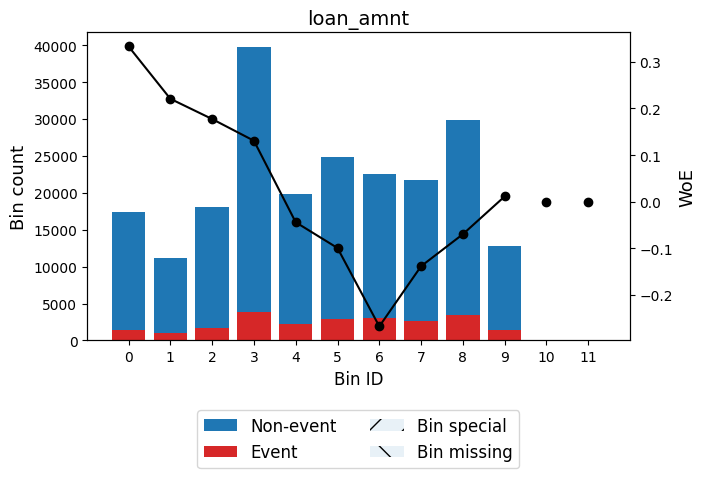


🔍 Feature: term
✅ Total IV for term: 0.0731
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │  155444 │             0.0908 │ 0.19235175980382557 │ 0.0244634 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   62547 │             0.1508 │ -0.3822295423979114 │ 0.0486122 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  217991 │             0.

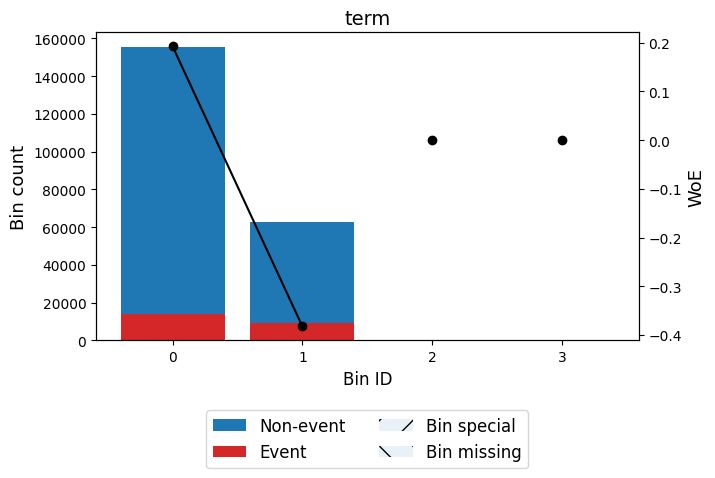


🔍 Feature: annual_inc
✅ Total IV for annual_inc: 0.0286
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 44236.50)       │   46760 │             0.1261 │ -0.17536812434680238  │ 0.00706435  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [44236.50, 54984.50)   │   30244 │             0.1215 │ -0.13276335980475062  │ 0.00257569  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [54984.50, 64967.00)   │   27082 │             0.1145 │ -0.06505391230519741  │ 0.000539324 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [64967.00, 74402.00)   │   24050 │             0.1078 │ 0.0022800761350785237

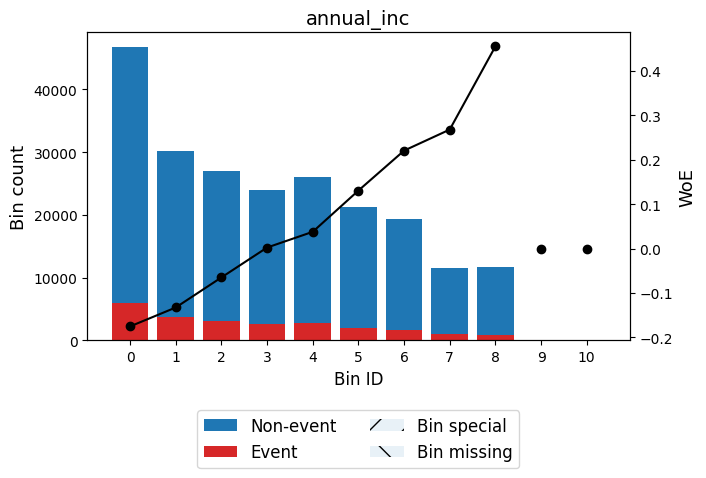


🔍 Feature: dti
✅ Total IV for dti: 0.0540
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 5.12)   │   11322 │             0.0682 │ 0.503941239108098     │ 0.0108239   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.12, 7.42)   │   10940 │             0.0763 │ 0.38239855521552757   │ 0.00631523  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.42, 10.48)  │   20410 │             0.0827 │ 0.29519955700444944   │ 0.00726561  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10.48, 12.99) │   21067 │             0.0894 │ 0.2102549988388045    │ 0.00393359  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼────

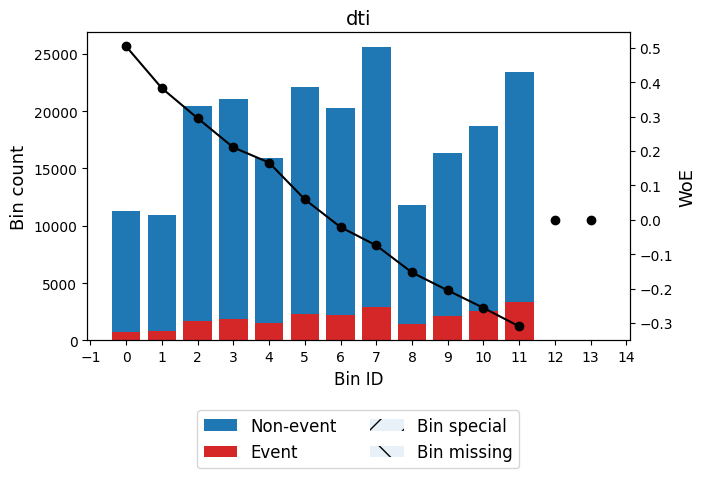


🔍 Feature: delinq_2yrs
✅ Total IV for delinq_2yrs: 0.0068
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  177492 │             0.1046 │ 0.03639202376418904  │ 0.00106305  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   27136 │             0.1168 │ -0.08805077840020248 │ 0.000998934 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │   13363 │             0.1361 │ -0.2630764278357536  │ 0.00470016  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Miss

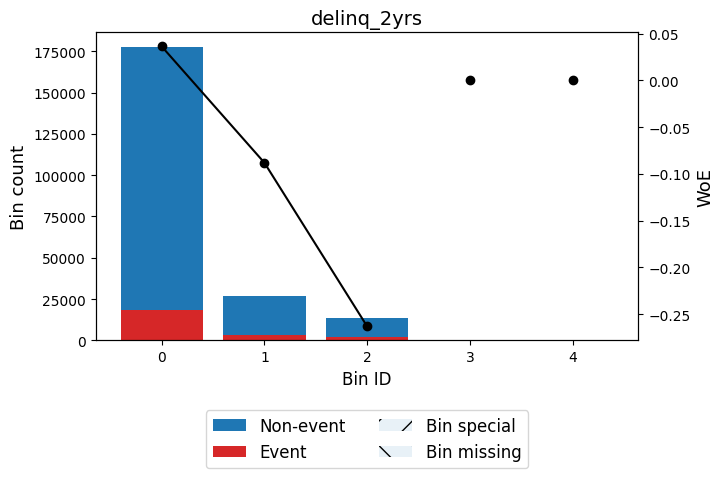


🔍 Feature: inq_last_6mths
✅ Total IV for inq_last_6mths: 0.0628
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │  133759 │             0.0905 │ 0.19642536220574724  │ 0.0219166  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   56077 │             0.1219 │ -0.13626490207162156 │ 0.00503783 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, inf)  │   28155 │             0.1637 │ -0.48001030885370444 │ 0.0358119  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing  

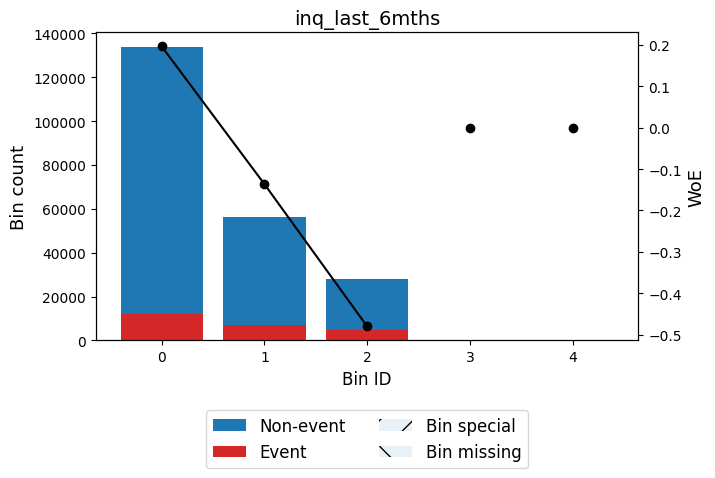


🔍 Feature: pub_rec
✅ Total IV for pub_rec: 0.0098
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │  183514 │             0.1038 │ 0.045137927316794446 │ 0.0016851  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, inf)  │   34477 │             0.1308 │ -0.21690060350855256 │ 0.00809737 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│              │  217991 

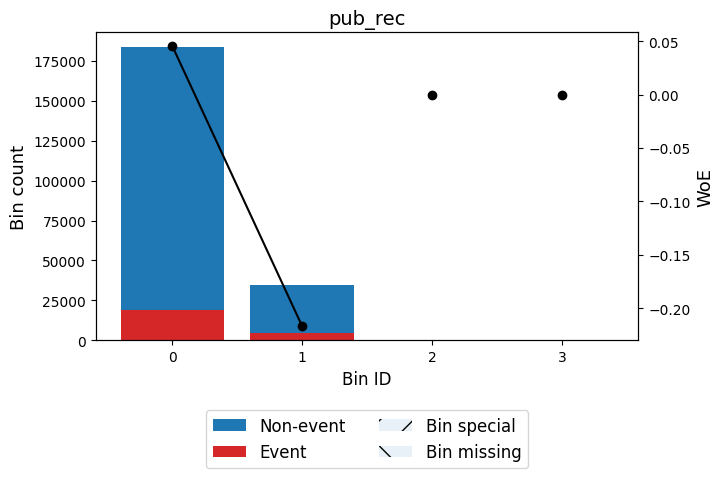


🔍 Feature: revol_util
✅ Total IV for revol_util: 0.0479
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 13.95)  │   17062 │             0.0685 │ 0.49969344534061433   │ 0.0160641   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13.95, 27.15) │   26410 │             0.0774 │ 0.3678550922777921    │ 0.0141885   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27.15, 33.95) │   17734 │             0.0954 │ 0.13899719768115748   │ 0.00148826  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [33.95, 38.55) │   13127 │             0.0996 │ 0.09110322756452893   │ 0.000482244 │
├────────────────┼─────────┼────────────────────┼──────────────

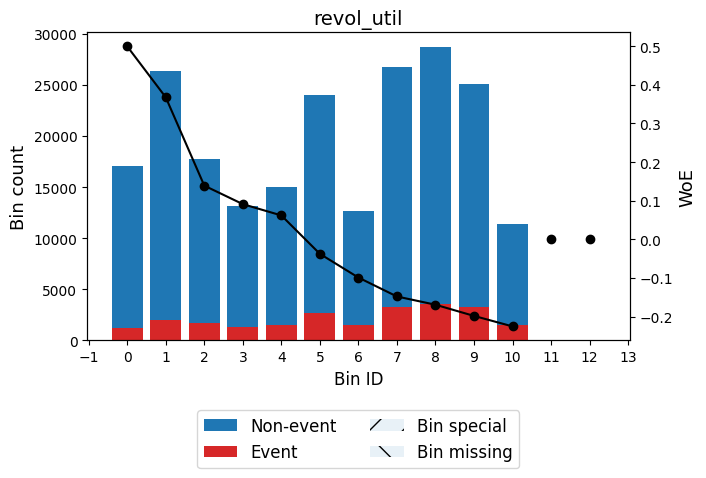


🔍 Feature: collections_12_mths_ex_med
✅ Total IV for collections_12_mths_ex_med: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


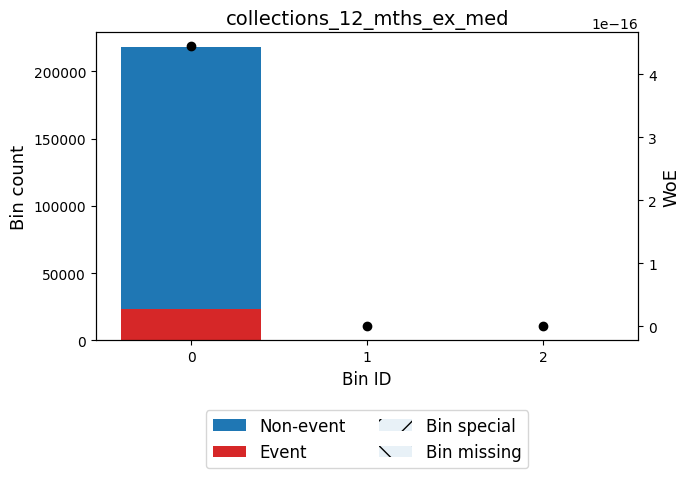


🔍 Feature: acc_now_delinq
✅ Total IV for acc_now_delinq: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


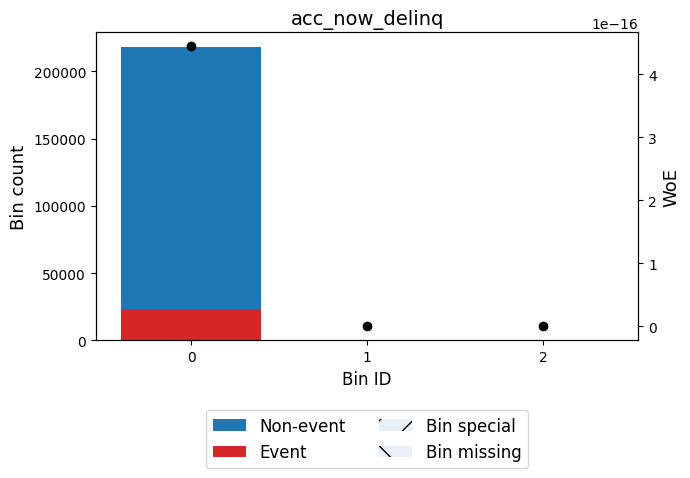


🔍 Feature: total_rev_hi_lim
✅ Total IV for total_rev_hi_lim: 0.0462
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6544.50)      │   12260 │             0.1149 │ -0.06957834104981098  │ 0.000279788 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6544.50, 25228.00)  │   91435 │             0.1216 │ -0.13384661065011638  │ 0.00791788  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [25228.00, 27405.00) │   15445 │             0.1345 │ -0.2490161033722209   │ 0.00484095  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27405.00, 32925.00) │   19204 │             0.1091 │ -0.010904262302927847 │ 1.051

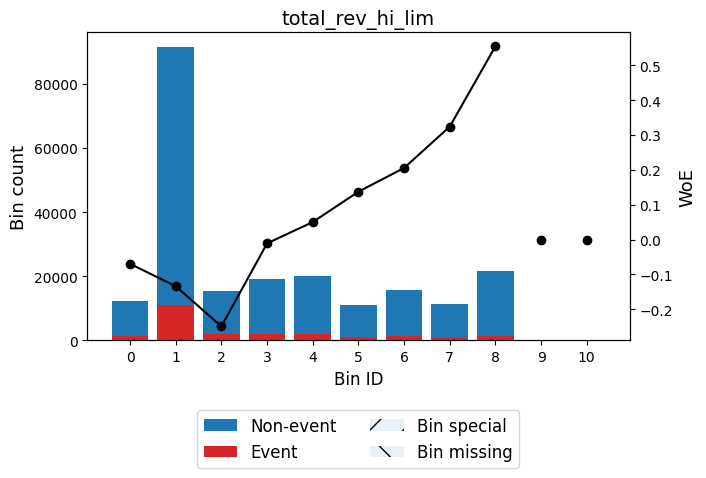


🔍 Feature: acc_open_past_24mths
✅ Total IV for acc_open_past_24mths: 0.0986
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50) │   31056 │             0.0678 │ 0.5093151765146797   │ 0.0302628   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   29566 │             0.0778 │ 0.3613046675534579   │ 0.0153628   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   32035 │             0.0898 │ 0.2054078233694696   │ 0.00571979  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50) │   34234 │             0.1098 │ -0.01820163898604399 │ 5.24008e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

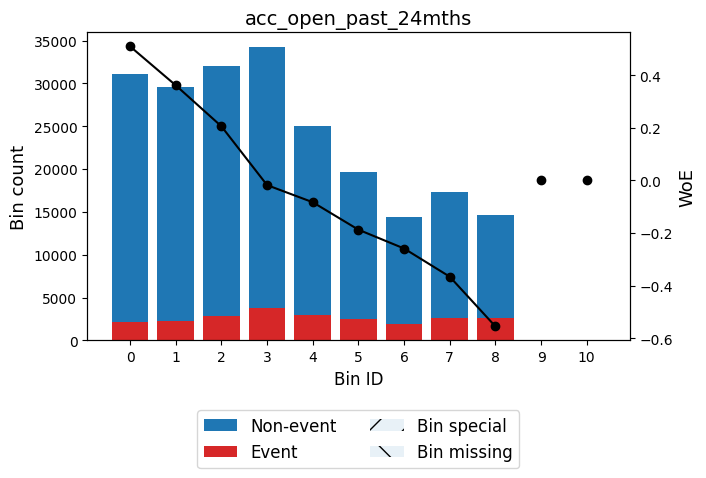


🔍 Feature: bc_open_to_buy
✅ Total IV for bc_open_to_buy: 0.0992
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 185.50)       │   11008 │             0.1508 │ -0.3826105354631786   │ 0.00857384  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [185.50, 553.50)     │   13513 │             0.1402 │ -0.29761856873538717  │ 0.00616445  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [553.50, 1450.50)    │   22040 │             0.1356 │ -0.25877463943984136  │ 0.00748822  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1450.50, 2394.50)   │   17742 │             0.1304 │ -0.2137489381968416   │ 0.0040417

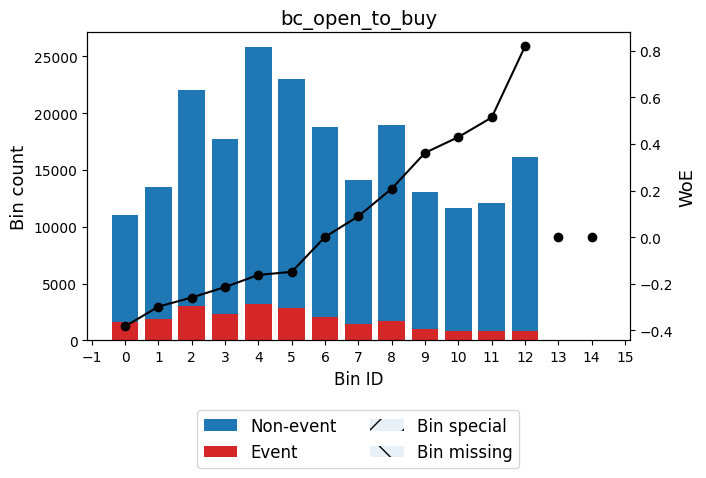


🔍 Feature: chargeoff_within_12_mths
✅ Total IV for chargeoff_within_12_mths: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


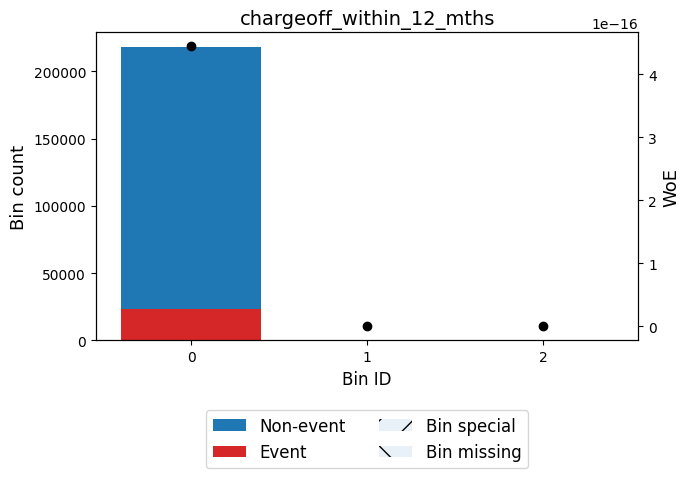


🔍 Feature: delinq_amnt
✅ Total IV for delinq_amnt: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


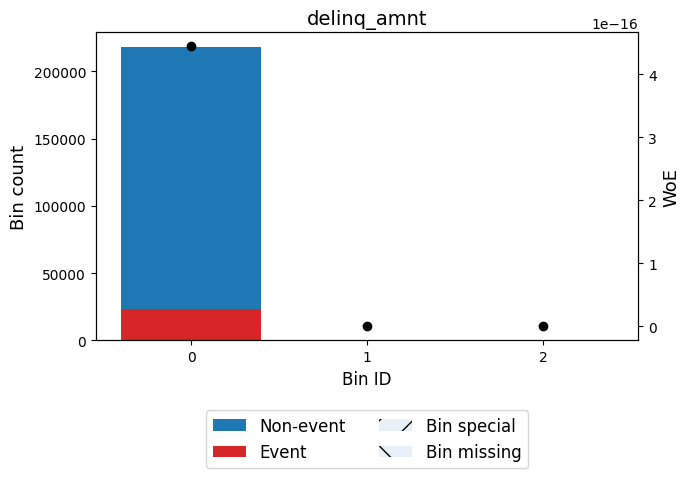


🔍 Feature: mo_sin_old_il_acct
✅ Total IV for mo_sin_old_il_acct: 0.0067
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 37.50)    │   13083 │             0.1153 │ -0.07289201938480483  │ 0.00032811  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [37.50, 131.50)  │  105659 │             0.1131 │ -0.05196407291405292  │ 0.00133571  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [131.50, 139.50) │   18676 │             0.1117 │ -0.037403602147565884 │ 0.000121628 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [139.50, 144.50) │   11020 │             0.1028 │ 0.05539643109778858   │ 0.000151799 │
├──────────────────┼───────

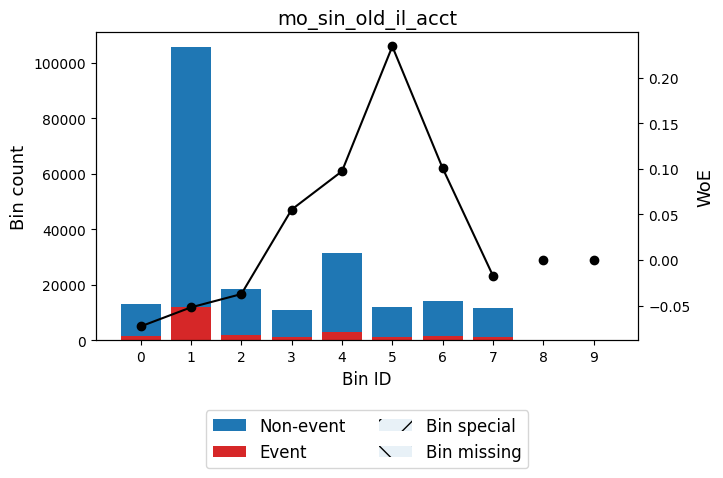


🔍 Feature: mo_sin_rcnt_rev_tl_op
✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0483
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   16427 │             0.1392 │ -0.28918860434355564  │ 0.00705237  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16194 │             0.1267 │ -0.18062118389781245  │ 0.0026006   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   15489 │             0.1261 │ -0.17496919880201278  │ 0.00232903  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50)   │   14218 │             0.121  │ -0.12771100908980992  │ 0.00111825  │
├────────────────┼─────────┼─────────────

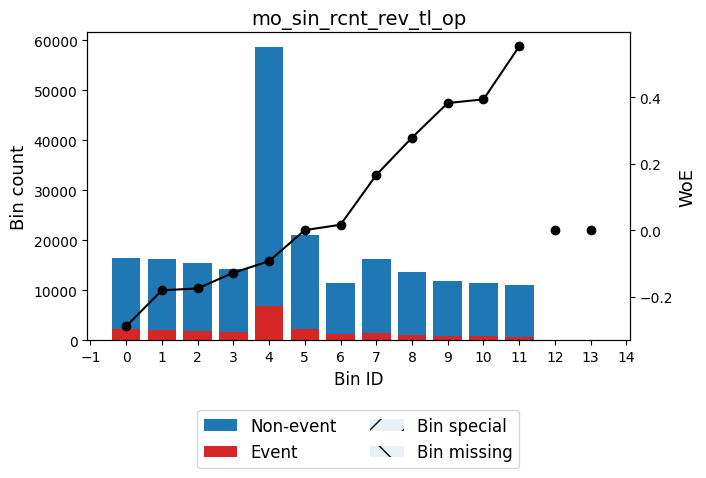


🔍 Feature: mo_sin_rcnt_tl
✅ Total IV for mo_sin_rcnt_tl: 0.0551
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   20653 │             0.1381 │ -0.27972121682809203 │ 0.00826543  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 3.50)   │   44554 │             0.1272 │ -0.18475303143650867 │ 0.00749807  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │   19666 │             0.1158 │ -0.07797631445300901 │ 0.000565531 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 6.50)   │   38304 │             0.1153 │ -0.0728727058729195  │ 0.000960115 │
├────────────────┼─────────┼────────────────────┼────────────────

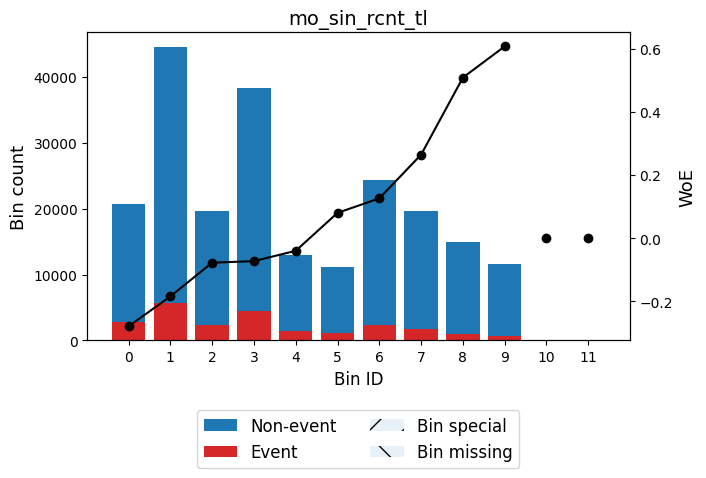


🔍 Feature: mort_acc
✅ Total IV for mort_acc: 0.0079
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50) │   89167 │             0.1164 │ -0.08408821887434614  │ 0.00298901  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50) │   42519 │             0.1112 │ -0.032624596071679335 │ 0.000210274 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   31702 │             0.0995 │ 0.09196004279663628   │ 0.00118624  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   22400 │             0.0971 │ 0.11893544863256977   │ 0.00138725  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│

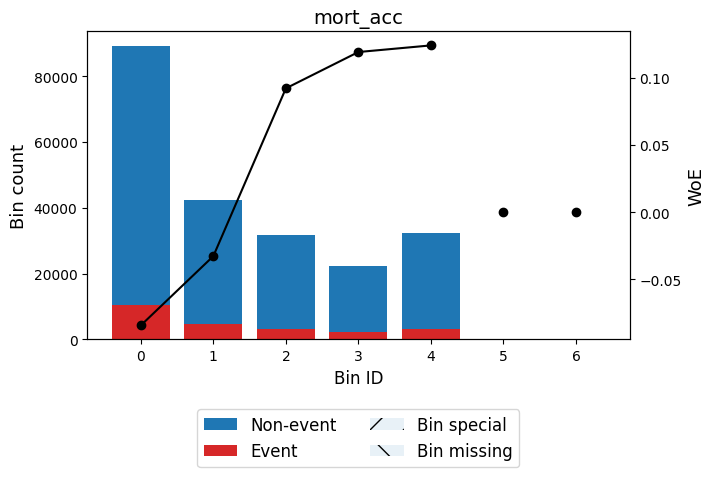


🔍 Feature: mths_since_recent_bc
✅ Total IV for mths_since_recent_bc: 0.0342
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   27927 │             0.1345 │ -0.24915634365418615 │ 0.00876353  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50)   │   18694 │             0.1226 │ -0.142479508312348   │ 0.00184056  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 8.50)   │   24062 │             0.1197 │ -0.11598825246186828 │ 0.00155388  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.50, 16.50)  │   54338 │             0.1156 │ -0.076096746856126   │ 0.00148707  │
├────────────────┼─────────┼────────────────────┼────

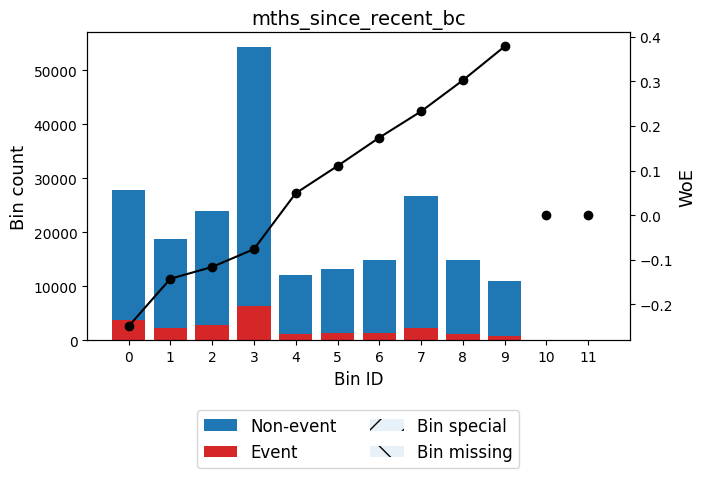


🔍 Feature: mths_since_recent_inq
✅ Total IV for mths_since_recent_inq: 0.0427
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50)   │   16331 │             0.146  │ -0.34447066759788414  │ 0.0101612   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50)   │   20266 │             0.1391 │ -0.288169847805549    │ 0.00863593  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16553 │             0.1275 │ -0.1874334291402837   │ 0.00287013  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   15054 │             0.1252 │ -0.1670175879432294   │ 0.00205619  │
├────────────────┼─────────┼─────────────

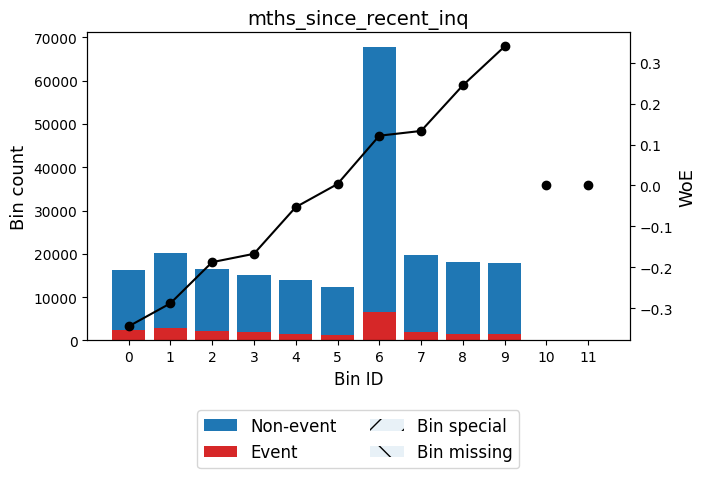


🔍 Feature: num_accts_ever_120_pd
✅ Total IV for num_accts_ever_120_pd: 0.0048
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  169461 │             0.1045 │ 0.03766075893541743  │ 0.00108641  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   26010 │             0.1233 │ -0.14904344478936404 │ 0.00280943  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │   22520 │             0.1174 │ -0.09330670098502836 │ 0.000932845 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─

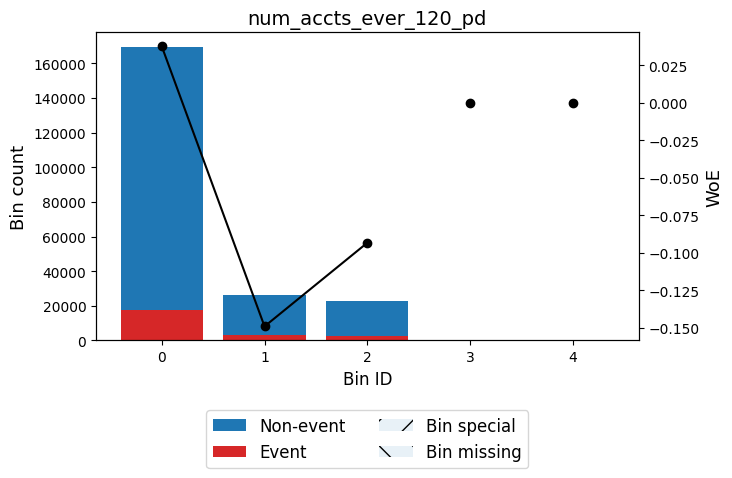


🔍 Feature: num_bc_tl
✅ Total IV for num_bc_tl: 0.0076
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)   │   16552 │             0.0945 │ 0.14904788903698307  │ 0.00159091  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50)   │   17572 │             0.0963 │ 0.12819384486361995  │ 0.00125968  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │   21522 │             0.1002 │ 0.08430894837125047  │ 0.000678927 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 5.50)   │   22089 │             0.1005 │ 0.08019750256147562  │ 0.000631527 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

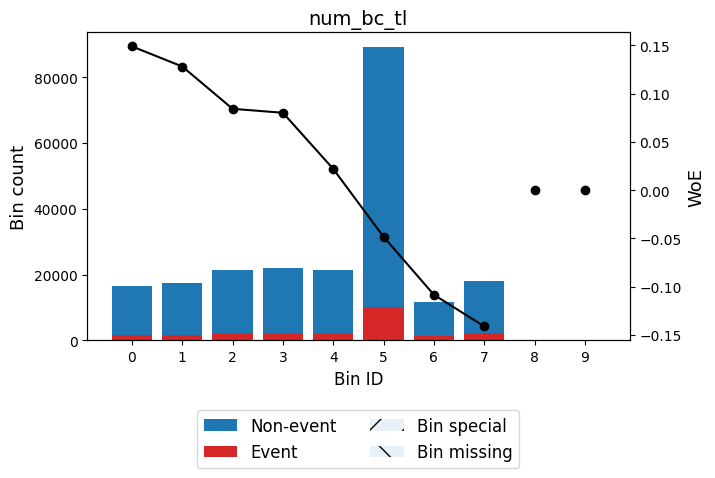


🔍 Feature: num_il_tl
✅ Total IV for num_il_tl: 0.0074
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   18979 │             0.0951 │ 0.14249306669664286   │ 0.00167157  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16495 │             0.0985 │ 0.10288259491902485   │ 0.000769237 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   18240 │             0.0998 │ 0.08809805031308171   │ 0.000627341 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 6.50)   │   52310 │             0.1031 │ 0.051909505260576694  │ 0.000633573 │
├────────────────┼─────────┼────────────────────┼────────────────

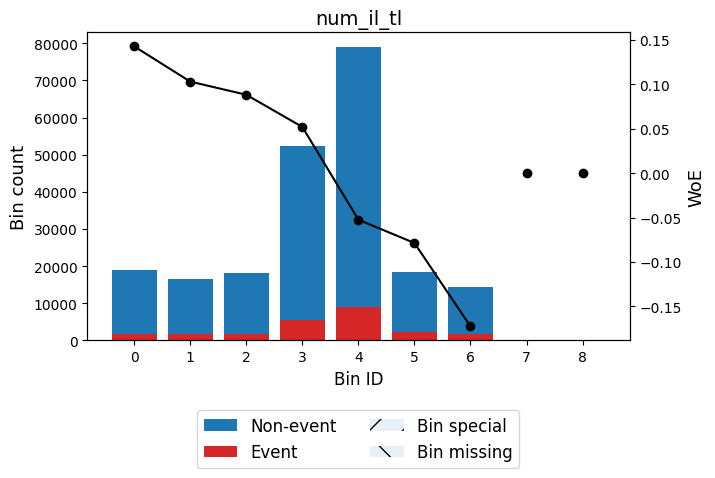


🔍 Feature: num_tl_120dpd_2m
✅ Total IV for num_tl_120dpd_2m: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


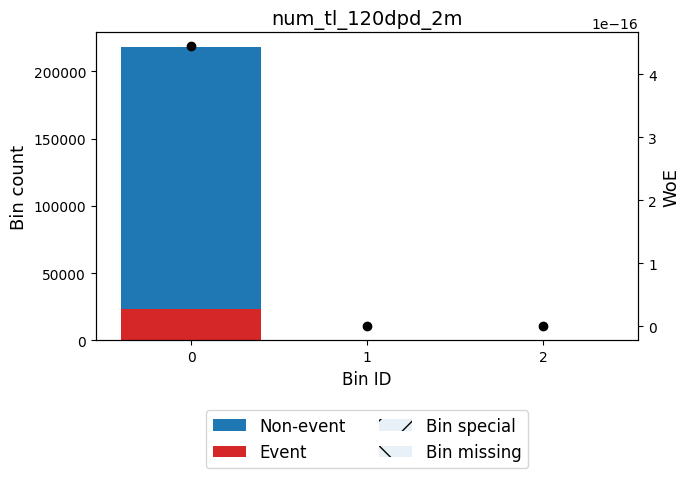


🔍 Feature: num_tl_90g_dpd_24m
✅ Total IV for num_tl_90g_dpd_24m: 0.0030
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  206775 │             0.1068 │ 0.013382506253671878 │ 0.000168988 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   11216 │             0.1317 │ -0.22482991034151878 │ 0.00283905  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────

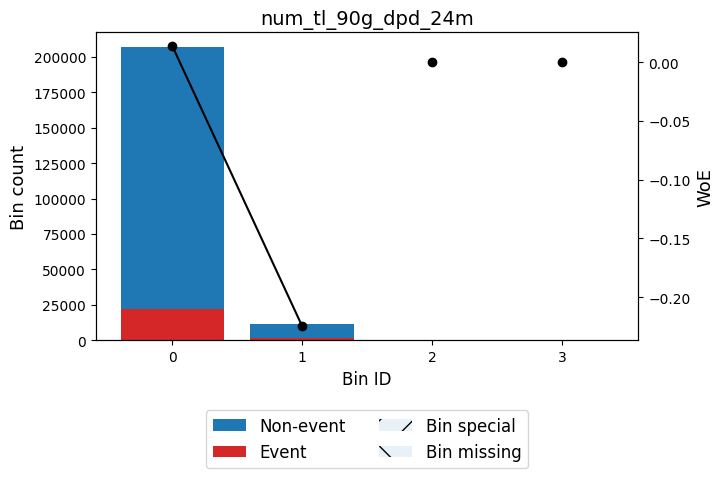


🔍 Feature: num_tl_op_past_12m
✅ Total IV for num_tl_op_past_12m: 0.0815
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50) │   40164 │             0.0715 │ 0.453189890567423     │ 0.031674    │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50) │   54174 │             0.0883 │ 0.22328635265773844   │ 0.0113497   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   53091 │             0.1111 │ -0.031513808091502504 │ 0.000244876 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   32354 │             0.1302 │ -0.2116298216770034   │ 0.00721918  │
├──────────────┼─────────┼────────────────────┼────────────────────

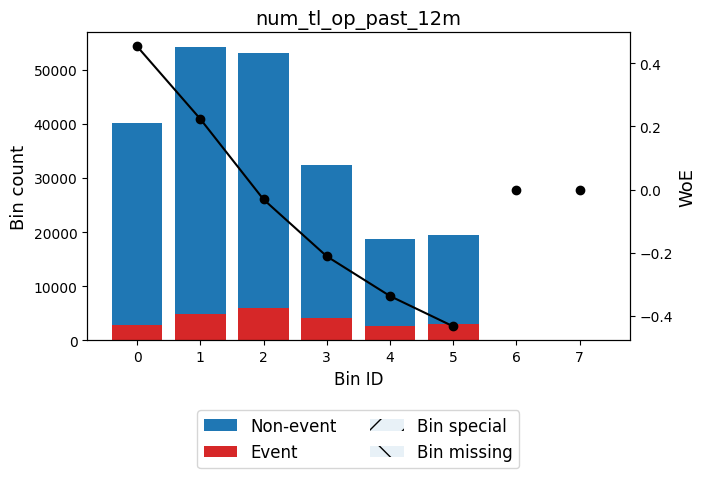


🔍 Feature: pct_tl_nvr_dlq
✅ Total IV for pct_tl_nvr_dlq: 0.0006
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 75.20) │   11054 │             0.0982 │ 0.10694494127680576   │ 0.000556123 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [75.20, inf)  │  206937 │             0.1086 │ -0.005466135436267727 │ 2.84244e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special       │       0 │             0      │ 0.0                   │ 0           │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Missing       │       0 │             0      │ 0.0                   │ 0           │
├───────────────┼─────────┼────────────────────┼─────────────────

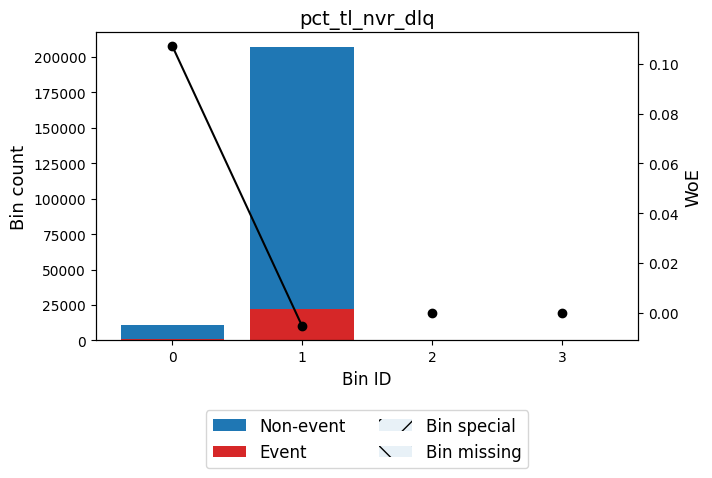


🔍 Feature: tot_hi_cred_lim
✅ Total IV for tot_hi_cred_lim: 0.0402
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 20291.50)       │   11684 │             0.1041 │ 0.041800851352586044  │ 9.21304e-05 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [20291.50, 36512.50)   │   20673 │             0.1199 │ -0.11771873342452155  │ 0.00137609  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [36512.50, 112547.00)  │   71947 │             0.1227 │ -0.14399111733324022  │ 0.00723905  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [112547.00, 126145.00) │   12936 │             0.1353 │ -0.25590814

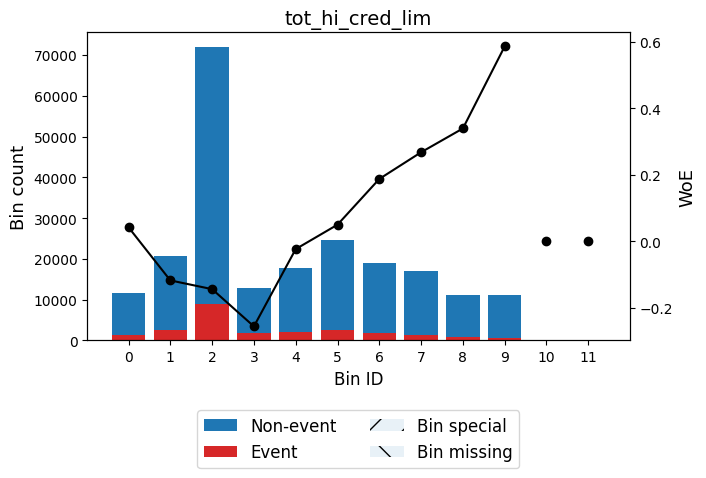


🔍 Feature: total_bal_ex_mort
✅ Total IV for total_bal_ex_mort: 0.0113
╒═══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 10630.50)      │   20935 │             0.0862 │ 0.250348284589474     │ 0.00545522  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10630.50, 21739.50)  │   34651 │             0.1023 │ 0.06122149173007818   │ 0.00058164  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [21739.50, 29885.50)  │   26561 │             0.1128 │ -0.048470855050617434 │ 0.00029175  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [29885.50, 37488.50)  │   22851 │             0.1155 │ -0.07507891986286

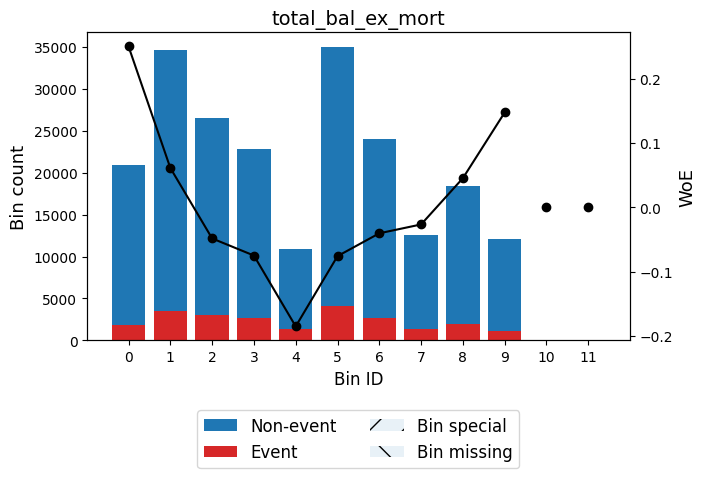


🔍 Feature: credit_history_years
✅ Total IV for credit_history_years: 0.0097
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6.54)   │   13284 │             0.0998 │ 0.0882782689237036    │ 0.000458725 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.54, 8.46)   │   10976 │             0.1152 │ -0.0718744111788614   │ 0.00026753  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [8.46, 10.21)  │   14721 │             0.1268 │ -0.18101961147863754  │ 0.00237486  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10.21, 11.46) │   17229 │             0.124  │ -0.15619352400628506  │ 0.00204949  │
├────────────────┼─────────┼───────────────

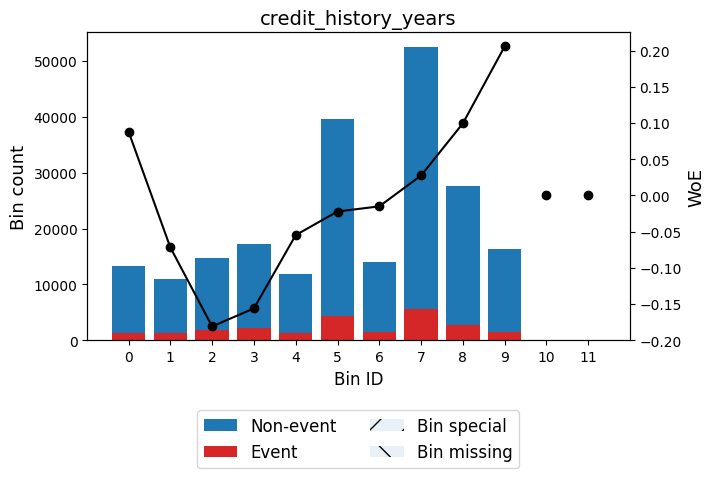


🔍 Feature: fico_score
✅ Total IV for fico_score: 0.1582
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 664.50)   │   17676 │             0.152  │ -0.39206408065623366 │ 0.0145082   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [664.50, 669.50) │   17177 │             0.1482 │ -0.36187508868525975 │ 0.0118736   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [669.50, 674.50) │   17577 │             0.146  │ -0.344520350286744   │ 0.0109398   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [674.50, 679.50) │   15831 │             0.135  │ -0.2534005454094779  │ 0.00514691  │
├──────────────────┼─────────┼────────────────────┼──

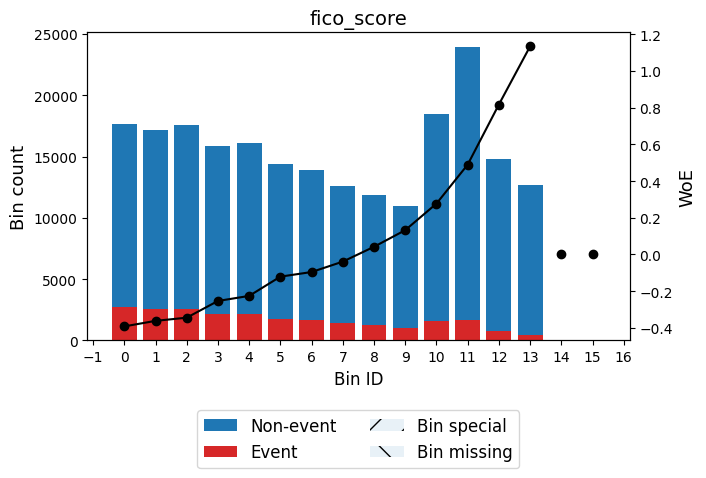


🔍 Feature: proportion_satisfac_accounts
✅ Total IV for proportion_satisfac_accounts: 0.0121
╒══════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                    │          IV │
╞══════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, 0.81) │   13344 │             0.0857 │ 0.2559497090102667     │ 0.00362652  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.81, 0.84) │   10927 │             0.088  │ 0.22686443220985053    │ 0.00235989  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.84, 0.86) │   14647 │             0.0941 │ 0.1530411725023031     │ 0.00148193  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.86, 0.88) │   16318 │             0.1017 │ 0.06788412032824809    │ 0.00033589  │
├──────────────┼─────────┼───────────

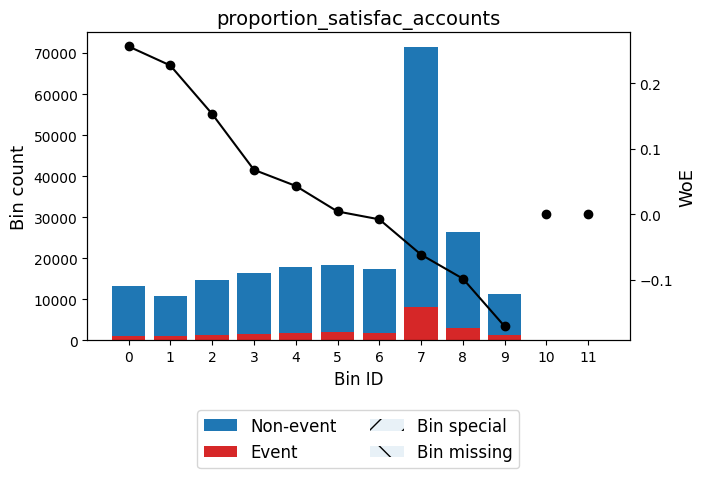


🔍 Feature: proportion_satisfac_bc_tl
✅ Total IV for proportion_satisfac_bc_tl: 0.0103
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.74) │   37966 │             0.105  │ 0.032308882873169686  │ 0.000179514 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.74, 0.76) │   22848 │             0.1093 │ -0.013364849586120275 │ 1.88197e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.76, 0.83) │   17320 │             0.1145 │ -0.06586735289067569  │ 0.000353711 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.83, 0.93) │   25797 │             0.1235 │ -0.15092689998242048  │ 0.00285938  │
├──────────────┼─────────┼────────────────────┼──────

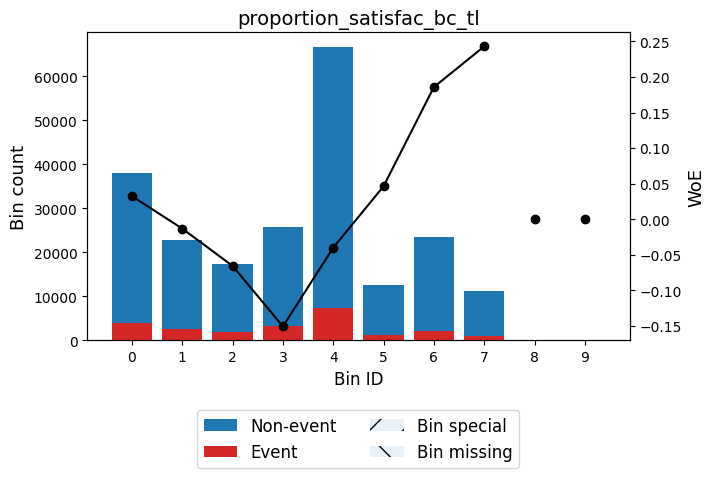

In [9]:
# =========================
# Main Execution
# =========================

numerical_cols = get_numerical_cols(df, TARGET_COL)

for feature in numerical_cols:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")
    sample_df = (
        df.select(feature, TARGET_COL)
        .sample(fraction=SAMPLE_FRAC, seed=SEED)
        .toPandas()
    )

    if sample_df[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = sample_df[feature], sample_df[TARGET_COL]
    first_bin_and_classify_feature(feature=feature, x=x, y=y, monotonic_trend_type='auto')

In [10]:
for key, val in iv_categories.items():
    print(f"\n⚡️ {key.capitalize()}\n Features ({len(val)}):")
    for feature, iv in val:
        print(f" - {feature}: {iv:.4f}")


⚡️ Useless (< 0.02)
 Features (18):
 - delinq_2yrs: 0.0068
 - pub_rec: 0.0098
 - collections_12_mths_ex_med: 0.0000
 - acc_now_delinq: 0.0000
 - chargeoff_within_12_mths: 0.0000
 - delinq_amnt: 0.0000
 - mo_sin_old_il_acct: 0.0067
 - mort_acc: 0.0079
 - num_accts_ever_120_pd: 0.0048
 - num_bc_tl: 0.0076
 - num_il_tl: 0.0074
 - num_tl_120dpd_2m: 0.0000
 - num_tl_90g_dpd_24m: 0.0030
 - pct_tl_nvr_dlq: 0.0006
 - total_bal_ex_mort: 0.0113
 - credit_history_years: 0.0097
 - proportion_satisfac_accounts: 0.0121
 - proportion_satisfac_bc_tl: 0.0103

⚡️ Weak (< 0.1)
 Features (15):
 - loan_amnt: 0.0277
 - term: 0.0731
 - annual_inc: 0.0286
 - dti: 0.0540
 - inq_last_6mths: 0.0628
 - revol_util: 0.0479
 - total_rev_hi_lim: 0.0462
 - acc_open_past_24mths: 0.0986
 - bc_open_to_buy: 0.0992
 - mo_sin_rcnt_rev_tl_op: 0.0483
 - mo_sin_rcnt_tl: 0.0551
 - mths_since_recent_bc: 0.0342
 - mths_since_recent_inq: 0.0427
 - num_tl_op_past_12m: 0.0815
 - tot_hi_cred_lim: 0.0402

⚡️ Medium (< 0.3)
 Features 

From the results above, we can categorise situations of WoE monotonicity for our numerical features into the following gameplans. 

- **Monotonic WoE & Medium IV**: `fico_score`, `bc_open_to_buy` (Accepted)
- **Monotonic WoE & Weak IV**: `term`, `annual_inc`, `dti`, ... 🚩 (Accepted)
- **Non-Monotonic WoE & Weak IV**: Preprocess to enforce WoE monotonicity constrant (and reassess IV Value)
- **Monotonic WoE & Useless IV**: Drop these variables (Unlikely to be helpful in predictive values, even when interaction features are created)
- **Non-Monotonic WoE & Useless IV**: Drop variables (`optbinning` has already attempted to optimise IV score. Non-monotonicity has already rendered best IV scores)

In [11]:
# Inspect IV score 

for key, value in iv_categories.items(): 
    print("👑 " + key.capitalize())
    
    for a_tuple in value: 
        print(a_tuple)
        
    print('\n################################\n')

👑 Useless (< 0.02)
('delinq_2yrs', np.float64(0.006762143980521645))
('pub_rec', np.float64(0.009782467672196097))
('collections_12_mths_ex_med', np.float64(0.0))
('acc_now_delinq', np.float64(0.0))
('chargeoff_within_12_mths', np.float64(0.0))
('delinq_amnt', np.float64(0.0))
('mo_sin_old_il_acct', np.float64(0.006667886616433656))
('mort_acc', np.float64(0.007931255732181569))
('num_accts_ever_120_pd', np.float64(0.004828682959684444))
('num_bc_tl', np.float64(0.007588933088295326))
('num_il_tl', np.float64(0.007374777416292187))
('num_tl_120dpd_2m', np.float64(0.0))
('num_tl_90g_dpd_24m', np.float64(0.0030080340689503313))
('pct_tl_nvr_dlq', np.float64(0.0005845470624135888))
('total_bal_ex_mort', np.float64(0.011270811148483977))
('credit_history_years', np.float64(0.009731113652143332))
('proportion_satisfac_accounts', np.float64(0.012058325285492577))
('proportion_satisfac_bc_tl', np.float64(0.01026338586727132))

################################

👑 Weak (< 0.1)
('loan_amnt', np.

In [12]:
# 1. Drop all useless numerical features 
useless_features_to_drop = []
for value in iv_categories.values(): 
    for feature, iv_score in value: 
        if iv_score < 0.02: 
            useless_features_to_drop.append(feature)
        

print("🗑️ Dropping useless features with IV < 0.04 ...")
df = df.drop(*useless_features_to_drop)
df.limit(10).toPandas() 

🗑️ Dropping useless features with IV < 0.04 ...


,id,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,tot_hi_cred_lim,fico_score
0,14639393,20000.0,60,E,MORTGAGE,60000.0,Verified,2014-05-01,0,n,...,8700.0,7.0,82.0,18.0,12.0,80.0,1.0,1.0,228569.0,672.0
1,14580137,20000.0,60,E,MORTGAGE,46962.0,Verified,2014-05-01,1,n,...,34600.0,6.0,2088.0,1.0,1.0,1.0,1.0,3.0,250522.0,672.0
2,14490894,4800.0,36,B,OWN,30000.0,Verified,2014-05-01,0,n,...,8300.0,6.0,1133.0,6.0,6.0,6.0,10.0,4.0,8300.0,677.0
3,14610358,10000.0,60,C,MORTGAGE,50000.0,Source Verified,2014-05-01,1,n,...,18800.0,4.0,8462.0,5.0,5.0,5.0,10.0,3.0,268285.0,697.0
4,14699258,27000.0,60,C,OWN,60206.0,Verified,2014-05-01,0,n,...,26300.0,4.0,3703.0,21.0,9.0,21.0,16.0,1.0,35596.0,697.0
5,14550710,8400.0,36,B,RENT,80000.0,Verified,2014-05-01,0,n,...,17600.0,4.0,7072.0,4.0,4.0,11.0,4.0,2.0,17600.0,712.0
6,14499399,10000.0,36,B,RENT,70000.0,Source Verified,2014-05-01,0,n,...,11100.0,1.0,723.0,25.0,1.0,25.0,1.0,1.0,101200.0,692.0
7,14460269,10800.0,60,C,RENT,35000.0,Source Verified,2014-05-01,0,n,...,18200.0,1.0,6176.0,14.0,14.0,14.0,13.0,0.0,29200.0,697.0
8,14528766,20000.0,36,B,RENT,90000.0,Verified,2014-05-01,1,n,...,25000.0,3.0,6737.0,10.0,1.0,10.0,1.0,2.0,50150.0,682.0
9,14580340,7800.0,36,B,MORTGAGE,35000.0,Source Verified,2014-05-01,1,n,...,22400.0,9.0,3661.0,14.0,14.0,17.0,14.0,0.0,106462.0,702.0


✅ Total IV for loan_amnt: 0.0277
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 4212.50)      │   17426 │             0.0799 │ 0.33301455593719353  │ 0.00777812  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4212.50, 5012.50)   │   11182 │             0.0885 │ 0.2206980849119704   │ 0.00229102  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5012.50, 7037.50)   │   18143 │             0.0921 │ 0.17728437034089328  │ 0.00243991  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7037.50, 10012.50)  │   39753 │             0.0961 │ 0.13073996449566305  │ 0.00296112  │
├──────────────────────┼─────────┼───

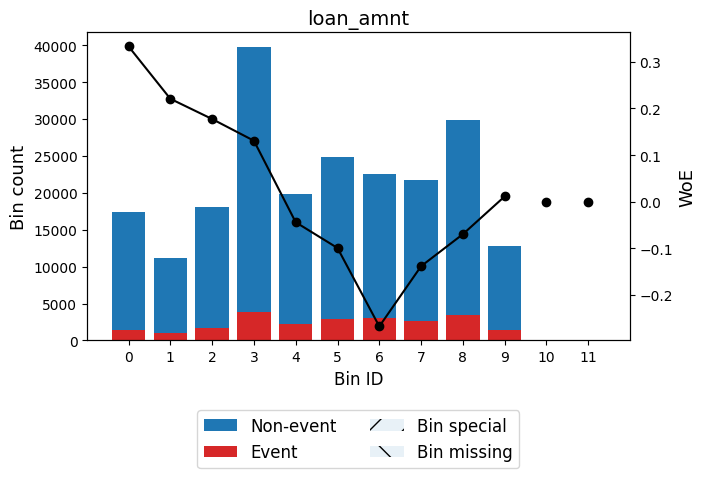

In [13]:
# 2. Deal with non-monotonic WoE & Weak IV Features ... 

# loan_amnt 
sampled_df = df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

first_bin_and_classify_feature('loan_amnt', sampled_df['loan_amnt'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto')

In [14]:
# first_bin_and_classify_feature('loan_amnt', sampled_df['loan_amnt'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto_asc_desc')

✅ Total IV for total_rev_hi_lim: 0.0462
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6544.50)      │   12260 │             0.1149 │ -0.06957834104981098  │ 0.000279788 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6544.50, 25228.00)  │   91435 │             0.1216 │ -0.13384661065011638  │ 0.00791788  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [25228.00, 27405.00) │   15445 │             0.1345 │ -0.2490161033722209   │ 0.00484095  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27405.00, 32925.00) │   19204 │             0.1091 │ -0.010904262302927847 │ 1.05197e-05 │
├───────────────────

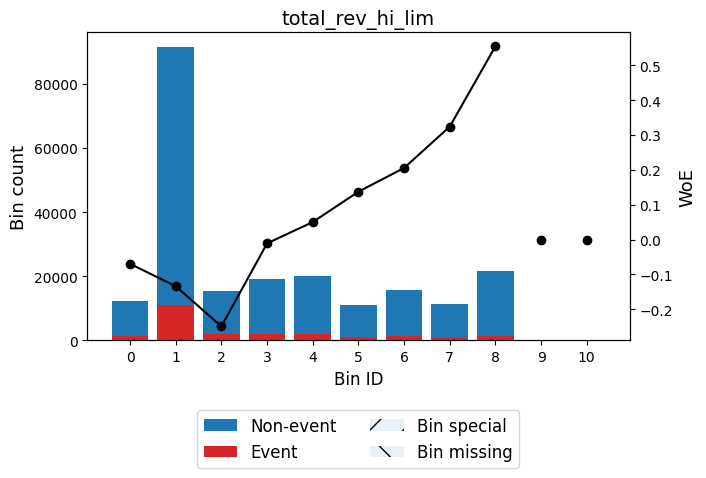

In [15]:
first_bin_and_classify_feature('total_rev_hi_lim', sampled_df['total_rev_hi_lim'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto')

✅ Total IV for total_rev_hi_lim: 0.0450
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 15618.50)     │   57266 │             0.1227 │ -0.14343687581936693  │ 0.00571639  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [15618.50, 27405.00) │   61874 │             0.1226 │ -0.1425057821439628   │ 0.00609424  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27405.00, 32925.00) │   19204 │             0.1091 │ -0.010904262302927847 │ 1.05197e-05 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [32925.00, 40383.50) │   20187 │             0.1033 │ 0.05029822438287601   │ 0.000229705 │
├───────────────────

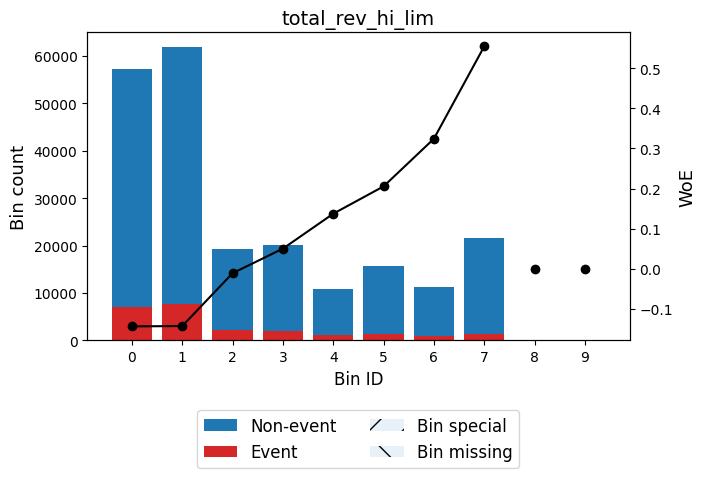

In [16]:
first_bin_and_classify_feature('total_rev_hi_lim', sampled_df['total_rev_hi_lim'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto_asc_desc')

✅ Total IV for tot_hi_cred_lim: 0.0402
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 20291.50)       │   11684 │             0.1041 │ 0.041800851352586044  │ 9.21304e-05 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [20291.50, 36512.50)   │   20673 │             0.1199 │ -0.11771873342452155  │ 0.00137609  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [36512.50, 112547.00)  │   71947 │             0.1227 │ -0.14399111733324022  │ 0.00723905  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [112547.00, 126145.00) │   12936 │             0.1353 │ -0.2559081413073647   │ 0.0042935   │
├

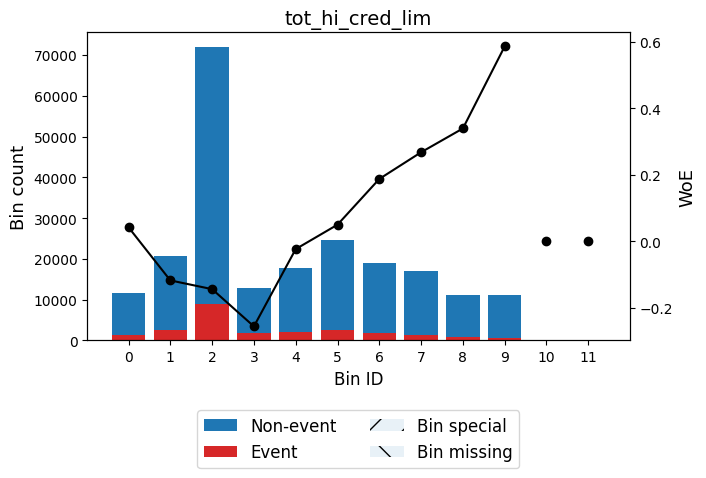

In [17]:
first_bin_and_classify_feature('tot_hi_cred_lim', sampled_df['tot_hi_cred_lim'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto')

✅ Total IV for tot_hi_cred_lim: 0.0376
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 126145.00)      │  117240 │             0.1218 │ -0.13499621367199266  │ 0.0103323   │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [126145.00, 171521.50) │   17664 │             0.1103 │ -0.023656100047231288 │ 4.5768e-05  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [171521.50, 241551.00) │   24676 │             0.1033 │ 0.04970467867104578   │ 0.000274261 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [241551.00, 308471.50) │   19072 │             0.0913 │ 0.18708179490984778   │ 0.00284518  │
├

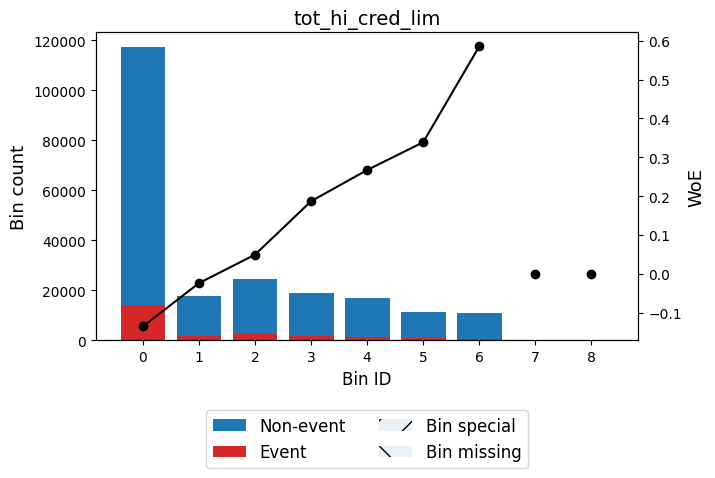

In [18]:
first_bin_and_classify_feature('tot_hi_cred_lim', sampled_df['tot_hi_cred_lim'], sampled_df[TARGET_COL], dtype='numerical', monotonic_trend_type='auto_asc_desc')

As seen from the above results for features in the category **Non-Monotonic WoE & Decent IV**, 
- `loan_amnt`: Changing `optbinning` settings to `auto_asc_dsc` enforces the monotonic rule, and IV dropped slightly to 0.003, which is acceptable 
- `total_rev_hi_lim`: (Same as above) -> IV dropped by 0.002 (acceptable)
- `tot_hi_cred_lim`: (Same as above) -> IV dropped by 0.003 

### 1.1.2 Categorical Features WoE & IV Feature Selection

✅ Total IV for grade: 0.4771
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ ['A']         │   42717 │             0.0302 │ 1.356737808180878    │ 0.21462    │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['B']         │   64666 │             0.0713 │ 0.455627205286786    │ 0.0514977  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['C']         │   62032 │             0.1213 │ -0.13085702661786436 │ 0.00512845 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['D']         │   30970 │             0.1723 │ -0.5412856292893911  │ 0.0512541  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['E' 'F' 'G'] │   17606 │         

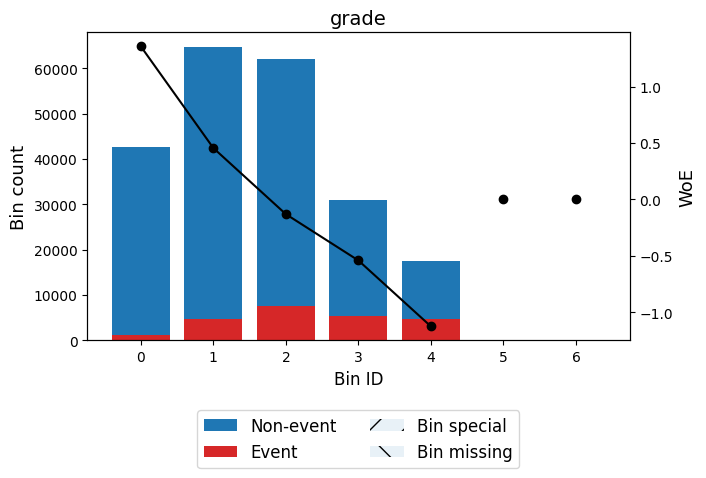

✅ Total IV for home_ownership: 0.0172
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ ['OTHER' 'MORTGAGE'] │  107683 │             0.0961 │ 0.13019621945405735  │ 0.00795621  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ ['OWN']              │   24453 │             0.1073 │ 0.008011119905777964 │ 7.17656e-06 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ ['RENT']             │   85855 │             0.1232 │ -0.14855707915418725 │ 0.00921131  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special              │       0 │             0      │ 0.0                  │ 0           │
├──────────────────────┼────────

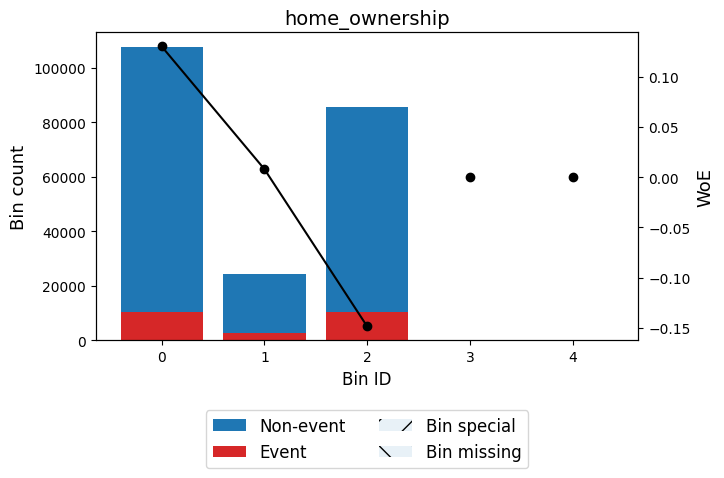

✅ Total IV for verification_status: 0.0951
╒═════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                 │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['Not Verified']    │   71893 │             0.0723 │ 0.440278741135939     │ 0.0537824   │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['Source Verified'] │   85754 │             0.1099 │ -0.019387334823332658 │ 0.000148988 │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['Verified']        │   60344 │             0.1479 │ -0.3596724245038809   │ 0.0411719   │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special             │       0 │             0      │ 0.0                   │ 0           │
├─────────────────────┼────

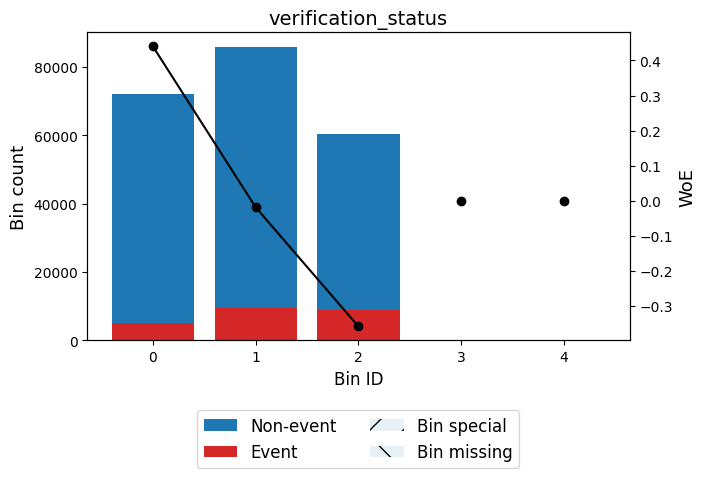

✅ Total IV for pymnt_plan: 0.0000
╒═════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ ['n']   │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special │       0 │              0     │ 0.0                   │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing │       0 │              0     │ 0.0                   │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│         │  217991 │              0.108 │                       │    0 │
╘═════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


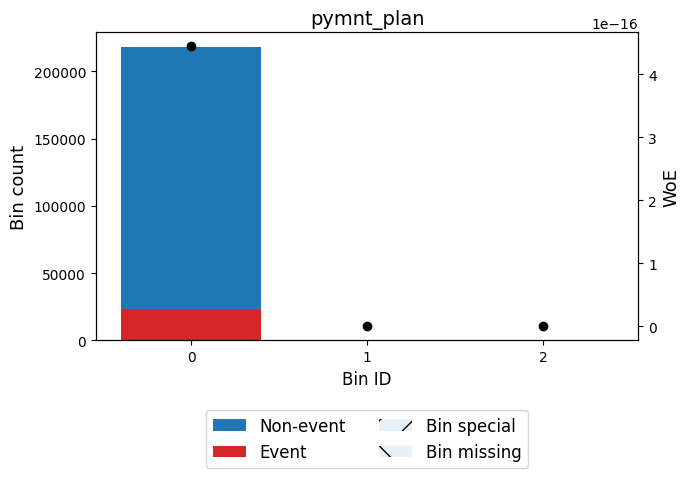

✅ Total IV for initial_list_status: 0.0461
╒═════════╤═════════╤════════════════════╤══════════════════════╤═══════════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                  │        IV │
╞═════════╪═════════╪════════════════════╪══════════════════════╪═══════════╡
│ ['w']   │  148406 │             0.0935 │ 0.16075064635224434  │ 0.0165159 │
├─────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ ['f']   │   69585 │             0.1391 │ -0.28777719826681647 │ 0.029567  │
├─────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ Special │       0 │             0      │ 0.0                  │ 0         │
├─────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ Missing │       0 │             0      │ 0.0                  │ 0         │
├─────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│         │  217991 │             0.108  │                      │ 0.0460829 │
╘═════════╧═════════╧

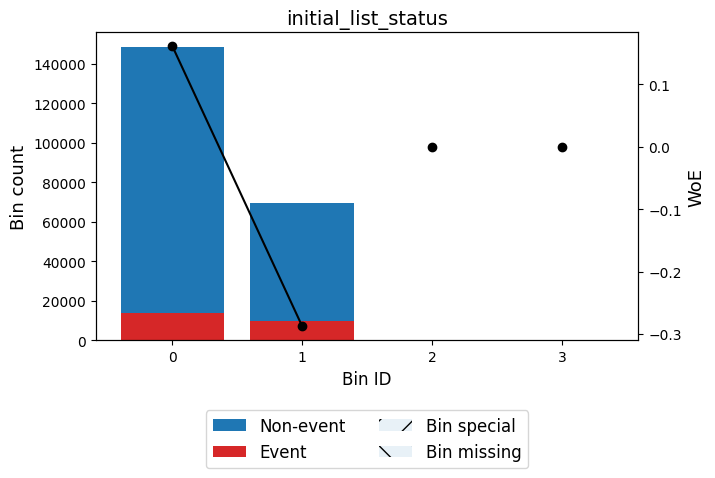

✅ Total IV for application_type: 0.0258
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ ['Joint App']  │   11300 │             0.0511 │ 0.8113486299407078   │ 0.0248663   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ ['Individual'] │  206691 │             0.1112 │ -0.03192196136688441 │ 0.000978347 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special        │       0 │             0      │ 0.0                  │ 0           │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing        │       0 │             0      │ 0.0                  │ 0           │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│  

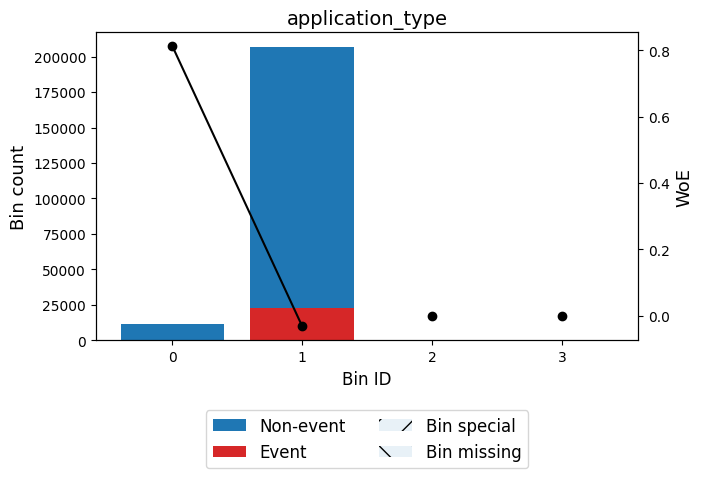

In [19]:
# 1. Start inspecting IV (Base Settings of optbinning 1st)
def get_categorical_cols(df): 
    """
    Get categorical columns from a Pyspark Dataframe & Return list of categorical columns 
    """
    
    return [column.name for column in df.schema.fields if isinstance(column.dataType, StringType)]
    
categorical_features = get_categorical_cols(df)

for cat_feature in categorical_features: 
    first_bin_and_classify_feature(cat_feature, sampled_df[cat_feature], sampled_df[TARGET_COL], dtype='categorical', monotonic_trend_type='auto')

For categorical features, we will drop `home_ownership` and `pymnt_plan` due to unsatisfactory IV Scores (<0.02) even when they are already binned optimally. The rest of the categorical features have IV scores >= 0.02 with monotonic WoE trends, making them interpretable for credit scorecards. 

In [20]:
df = df.drop(col('home_ownership'), col('pymnt_plan'))

## 1.1.3 Actual Binning of all Features 

In [21]:
# 1. Removal of Unimportant Columns
df = df.drop( col('id') , col('earliest_cr_line')) #! remove issue_d column later on (sort before feeding into machine learning model)

In [26]:
# 2. Binning Numerical Features 

def generate_woe_expr(col_name, splits, woes):
    """
    
    Generate a PySpark conditional expression to assign Weight of Evidence (WoE) values
    to a numerical column based on trained optbinning model's split points & woe values.
    
    This function constructs a series of `when` conditions that map the input column's value
    to its appropriate WoE score based on bin intervals.
    
    splits : list of float
        A list of bin boundary values (from optbinning.splits), assumed to be in ascending order.
        For example: [5000, 10000, 20000] defines bins:
            - (-inf, 5000]
            - (5000, 10000]
            - (10000, 20000]
            - (20000, +inf)
            
    woes: woe values corresponding to each bin 
    
    
    """
    expr = when(col(col_name) <= splits[0], float(woes[0])) # allocate WoE value to 1st bin 
    
    # Allocating each WoE Value in all the bins, including the last bin 
    for i in range(1, len(splits)):
        expr = expr.when(
            (col(col_name) > splits[i - 1]) & (col(col_name) <= splits[i]),
            float(woes[i])
        )
    expr = expr.otherwise(float(woes[-1]))
    return expr

def generate_woe_expr_categorical(col_name, categories, woes):
    expr = None
    for cat, woe in zip(categories, woes):
        # Ensure category is a native Python string
        cond = (col(col_name) == str(cat))
        if expr is None:
            expr = when(cond, float(woe))
        else:
            expr = expr.when(cond, float(woe))
    expr = expr.otherwise(float(woes[-1]))
    return expr


def woe_binning_transform(df, feature, target_col="default_status", date_col="issue_d", split_date="2017-08-01", monotonicity='auto', dtype='numerical'):
    """
    Fits WoE binning on train_df (split by date), then applies transformation to full df.
    
    Parameters:
    - df: PySpark DataFrame
    - feature: str, column to bin
    - target_col: str, target column for PD model (e.g. default_status)
    - date_col: str, time-based split column
    - split_date: str, boundary date for out-of-time split (e.g. '2017-08-01')
    
    Returns:
    - df: PySpark DataFrame with additional column <feature>_woe
    """

    # -- 1. Split into train set for fitting WoE --
    train_df = df.filter(col(date_col) < split_date).cache() 
    _ = train_df.count() 

    # -- 2. Convert train set to Pandas for optbinning
    train_pdf = train_df.select(feature, target_col).dropna().toPandas()

    # -- 3. Fit OptimalBinning to train set 
    optb = OptimalBinning(name=feature, dtype=dtype, monotonic_trend=monotonicity)
    
    try:
        optb.fit(train_pdf[feature], train_pdf[target_col])
    except Exception as e:
        print(f"❌ Error fitting {feature}: {e}")
        return df
    
    # -- 5. Get WoE values 
    opt_table = optb.binning_table.build()
    opt_table = opt_table.reset_index(drop=True)     
    woe_df     = opt_table[~opt_table["Bin"].astype(str)
                       .isin(["Special", "Missing",""])]
    
    woe_values = woe_df["WoE"].tolist()          
    new_col_name = feature + "_woe"

    # -- 4. Get bin edges 
    if dtype=='numerical': 
        splits      =    [-float("inf")] + list(optb.splits) + [float("inf")]

        def numeric_expr(c, s, w):
            expr = when(col(c) <= s[1], float(w[0]))
            for i in range(1, len(w)):
                expr = expr.when((col(c) > s[i]) & (col(c) <= s[i+1]), float(w[i]))
            return expr.otherwise(float(w[-1]))

        df = df.withColumn(new_col_name, numeric_expr(feature, splits, woe_values))
    else: 
        categories = woe_df["Bin"].tolist()
        woe_values = woe_df["WoE"].tolist()

        expr = None
        for cat, w in zip(categories, woe_values):
            expr = when(col(feature) == str(cat), float(w)) if expr is None else expr.when(col(feature) == str(cat), float(w))
        expr = expr.otherwise(float(woe_values[-1]))

        df = df.withColumn(new_col_name, expr)
        

    df = df.drop(col(feature))  # Drop original column
    
    train_df.unpersist()

    return df


In [27]:
# 3. Separate between numerical features that need me to use manual binning vs automated binning using optbinning 
# manual_binning_numerical_features = ['loan_amnt', 'total_rev_hi_lim', 'tot_hi_cred_lim']
manual_binning_numerical_features = ['total_rev_hi_lim', 'tot_hi_cred_lim']
rest_numerical_features = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType) and f.name not in manual_binning_numerical_features]


# 4. WoE fitting of Optbinning model based on train_df (sampled)
for num_feature in rest_numerical_features: 
    if num_feature != 'default_status': 
        print(f"🖖🏻 WoE Binning {num_feature} now ..." )
        df = woe_binning_transform(df, num_feature)
    else: 
        print('Skipping default_status ...')



🖖🏻 WoE Binning loan_amnt now ...


25/07/24 23:39:09 WARN CacheManager: Asked to cache already cached data.


🖖🏻 WoE Binning term now ...


🖖🏻 WoE Binning annual_inc now ...


Skipping default_status ...
🖖🏻 WoE Binning dti now ...
🖖🏻 WoE Binning inq_last_6mths now ...
🖖🏻 WoE Binning revol_util now ...
🖖🏻 WoE Binning acc_open_past_24mths now ...


🖖🏻 WoE Binning bc_open_to_buy now ...


🖖🏻 WoE Binning mo_sin_rcnt_rev_tl_op now ...


🖖🏻 WoE Binning mo_sin_rcnt_tl now ...


🖖🏻 WoE Binning mths_since_recent_bc now ...


🖖🏻 WoE Binning mths_since_recent_inq now ...


🖖🏻 WoE Binning num_tl_op_past_12m now ...


🖖🏻 WoE Binning fico_score now ...


In [28]:
# 5. WoE bin numerical features that require manual_binning (in our case -> auto_asc_desc is sufficient, due to how 
# enforcing monotonicity constraint only decreased IV score by a bit )
for numeric_feature_manual in manual_binning_numerical_features: 
    print(f"🖖🏻 WoE Binning {numeric_feature_manual} now ..." )
    df = woe_binning_transform(df, numeric_feature_manual, monotonicity='auto_asc_desc', dtype='numerical')

🖖🏻 WoE Binning total_rev_hi_lim now ...


🖖🏻 WoE Binning tot_hi_cred_lim now ...


In [29]:
# 3. Binning Categorical Features 
updated_cat_features = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

for cat_feature in updated_cat_features: 
    print(f"🖖🏻 WoE Binning {cat_feature} now ..." )
    df = woe_binning_transform(df, cat_feature, dtype='categorical', monotonicity='auto')
    

🖖🏻 WoE Binning grade now ...


🖖🏻 WoE Binning verification_status now ...


🖖🏻 WoE Binning initial_list_status now ...


🖖🏻 WoE Binning application_type now ...


In [30]:
checkpoint = df.limit(10).toPandas()
checkpoint

,issue_d,default_status,loan_amnt_woe,term_woe,annual_inc_woe,dti_woe,inq_last_6mths_woe,revol_util_woe,acc_open_past_24mths_woe,bc_open_to_buy_woe,...,mths_since_recent_bc_woe,mths_since_recent_inq_woe,num_tl_op_past_12m_woe,fico_score_woe,total_rev_hi_lim_woe,tot_hi_cred_lim_woe,grade_woe,verification_status_woe,initial_list_status_woe,application_type_woe
0,2014-05-01,0,-0.141035,-0.433358,-0.088393,-0.286120,-0.110647,-0.019313,-0.265650,-0.320890,...,0.309349,-0.269235,0.203031,-0.261071,-0.112541,0.131214,-0.994017,-0.247501,-0.095668,0.0
1,2014-05-01,1,-0.141035,-0.433358,-0.101618,0.020951,-0.110647,-0.083682,-0.174591,-0.154705,...,-0.251908,-0.269235,-0.179358,-0.261071,-0.006292,0.131214,-0.994017,-0.247501,-0.095668,0.0
2,2014-05-01,0,0.239111,0.211215,-0.208025,-0.442713,0.164247,0.232712,-0.174591,-0.154705,...,-0.112706,0.140065,-0.315970,-0.215742,-0.112541,-0.141525,-0.994017,-0.247501,-0.095668,0.0
3,2014-05-01,1,0.078536,-0.433358,-0.101618,0.194983,0.164247,-0.000324,0.040758,0.036763,...,-0.112706,0.140065,-0.179358,-0.004668,-0.103887,0.131214,-0.994017,-0.247501,-0.095668,0.0
4,2014-05-01,0,-0.141035,-0.433358,-0.088393,0.020951,0.164247,-0.083682,0.040758,-0.084805,...,0.071599,0.159881,0.203031,-0.004668,-0.036457,-0.141525,-0.994017,-0.247501,-0.095668,0.0
5,2014-05-01,0,0.153164,0.211215,0.052651,0.355848,-0.110647,-0.083682,0.040758,0.003178,...,-0.058883,-0.084736,0.003019,0.220221,-0.103887,-0.141525,-0.994017,-0.247501,-0.095668,0.0
6,2014-05-01,0,0.078536,0.211215,-0.013528,0.094664,-0.372610,-0.083682,0.486461,-0.178558,...,0.109028,-0.269235,0.203031,-0.048943,-0.112541,-0.132407,-0.994017,-0.247501,-0.095668,0.0
7,2014-05-01,0,-0.023120,-0.433358,-0.195126,0.194983,0.164247,-0.083682,0.486461,0.003178,...,-0.025962,0.159881,0.398455,-0.004668,-0.103887,-0.141525,-0.994017,-0.247501,-0.095668,0.0
8,2014-05-01,1,-0.141035,0.211215,0.131261,0.194983,-0.110647,-0.109645,0.176807,0.003178,...,-0.067815,-0.269235,0.003019,-0.175785,-0.082933,-0.141525,-0.994017,-0.247501,-0.095668,0.0
9,2014-05-01,1,0.153164,0.211215,-0.195126,-0.219680,0.164247,0.073563,-0.371790,-0.084805,...,0.016099,0.159881,0.398455,0.078036,-0.082933,-0.132407,-0.994017,-0.247501,-0.095668,0.0


In [31]:
# Multicollinearity Check Again 
newest_numeric = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType) and field.name != 'default_status']
to_keep1, to_drop1 = calculate_vif(df,newest_numeric , threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep1:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop1:
    print(f" - {feature}: {vif}")


25/07/24 23:40:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/07/24 23:40:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/07/24 23:40:48 WARN Instrumentation: [7b49e425] The standard deviation of the label is zero, so the coefficients will be zeros and the intercept will be the mean of the label; as a result, training is not needed.
25/07/24 23:40:49 WARN Instrumentation: [bb712bec] The standard deviation of the label is zero, so the coefficients will be zeros and the intercept will be the mean of the label; as a result, training is not needed.


✅ Features to Keep (VIF <= 5.0):
 - loan_amnt_woe: 1.5531155725460632
 - term_woe: 1.2591328291355712
 - annual_inc_woe: 1.8747823531852994
 - dti_woe: 1.3132570204259457
 - inq_last_6mths_woe: 1.9145313115182363
 - revol_util_woe: 2.1207406480331246
 - acc_open_past_24mths_woe: 2.541613704507152
 - bc_open_to_buy_woe: 3.2892488353041593
 - mo_sin_rcnt_rev_tl_op_woe: 2.9373934574372185
 - mo_sin_rcnt_tl_woe: 2.783368836545131
 - mths_since_recent_bc_woe: 1.998898766390362
 - mths_since_recent_inq_woe: 1.8994052722439863
 - num_tl_op_past_12m_woe: 3.176459230784336
 - fico_score_woe: 1.7035606526299019
 - total_rev_hi_lim_woe: 2.664147041686539
 - tot_hi_cred_lim_woe: 1.5955828190127548
 - grade_woe: 0.0
 - verification_status_woe: 0.0
 - initial_list_status_woe: 0.0

❌ Features to Drop (VIF > 5.0):


25/07/24 23:40:49 WARN Instrumentation: [1cddbf80] Mean and standard deviation of the label are zero, so the coefficients and the intercept will all be zero; as a result, training is not needed.


In [32]:
run_model_checkpoint(df, "logistic_regression_after_feature_selection", '2017-08-01', 0.05, 'logistic_regression_v1.5', 'pd_model_building_2')

Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.67954
F1 Score,0.78486
Gini,0.32139
Model Type,logistic_regression_...
Precision,0.95367
Recall,0.67954


In [ ]:
#! Add back domain-specific features ... 
#! Remove 一定要 monotonic relationship for categorical features (lose precision on some buckets)

## 2. Feature Engineering 